# 3. Routing / Supervisor

## Overview

The Routing/Supervisor pattern is a powerful agent architecture that acts as an intelligent dispatcher. Instead of having one agent handle all types of requests, this pattern:

- **Routes requests** to specialized agents based on intent
- **Manages multiple sub-agents** with different capabilities
- **Provides fallback handling** for unrecognized requests
- **Scales efficiently** by distributing workload

![Routing Architecture](../docs/router_supervisor.png)

### Key Components

1. **Router Function**: Analyzes incoming requests and determines the appropriate handler
2. **Specialized Agents**: Purpose-built agents for specific domains (weather, travel, etc.)
3. **Fallback Handler**: Manages requests that don't match any specialized agent
4. **State Graph**: Orchestrates the flow between different components

## Implementation Steps

### Step 1: Import Required Libraries

We'll need:
- **LangChain**: For LLM integration and message handling
- **LangGraph**: For building the routing state machine
- **Typing**: For structured output validation

In [1]:
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from typing import Literal
from langchain.tools import tool
from langgraph.prebuilt import create_react_agent

### Step 2: Initialize the Base Language Model

This LLM will be used by both the router and the specialized agents.

In [2]:
llm = AzureChatOpenAI(model="gpt-4.1-mini")

### Step 3: Create Specialized Agents

First, we'll create a weather agent that can access weather information. We use:
- **The same weather tool** from the previous notebook
- **`create_react_agent()`**: A pre-built agent that automatically handles tool calling cycles

The ReAct agent handles the tool calling workflow automatically, so we don't need to manually manage the tool execution loop.

In [3]:
@tool
def weather_tool(location: Literal["Chicago", "New York", "Los Angeles"]) -> str:
    """
    Get the current weather for a specified location.
    Args:
        location (str): The name of the city to get the weather for. 
                        Must be one of "Chicago", "New York", or "Los Angeles".
    Returns:
        str: A string describing the current weather in the specified location.
    """

    weather_data = {
        "New York": "Sunny, 25°C",
        "Los Angeles": "Cloudy, 22°C",
        "Chicago": "Rainy, 18°C"
    }
    return weather_data.get(location, "Weather data not available for this location.")

weather_agent = create_react_agent(
    model=llm,
    tools=[weather_tool]
)

### Step 4: Define Router Output Structure

We use Pydantic to create a structured output format for the router. This ensures:
- **Consistent routing decisions** 
- **Type safety** with predefined options
- **Clear documentation** of available routes

The router can choose between `travel_advisor`, `weather`, or `unknown` for unhandled requests.

In [4]:
from pydantic import BaseModel

class RouterOutput(BaseModel):
    """Output of the router, indicating which tool to use. Set to 'unknown' if no tool is applicable.
    Options:
     - travel_advisor: If user is requesting travel advice.
     - weather: If user is requesting weather information.
     - unknown: If you are not sure what tool to use.
    """
    tool: Literal["travel_advisor", "unknown", "weather"]

### Step 5: Implement the Router Function

The router function is the brain of our system. It:
- **Analyzes the user's message** to understand intent
- **Uses structured output** to ensure valid routing decisions
- **Returns the appropriate route** for the request

The `with_structured_output()` method forces the LLM to respond in our predefined format.

In [5]:
def router(state) -> Literal["travel_advisor", "unknown", "weather"]:
    structured_llm = llm.with_structured_output(RouterOutput)
    response = structured_llm.invoke(input=state["messages"])
    print(f"Router response: {response}")
    return response.tool


### Step 6: Create Additional Specialized Agents

Now we'll create handlers for different types of requests:

#### Travel Advisor Agent
Handles travel-related queries with travel expertise.

In [6]:
def travel_advisor(state) -> str:
    print("Node: Travel Advisor")
    msgs = [
        SystemMessage("You are a travel expert. Based on the user's input, suggest 1 travel destination."),
        state["messages"][-1],
    ]
    response = llm.invoke(msgs)

    return {
        "messages": [response]
    }

#### Unknown Request Handler
Provides a helpful fallback for requests that don't match any specialized agent.

In [7]:
def unknown_node(state):
    print("Node: Unknown")
    return {
        "messages": [
            AIMessage(content="I can not assist with that request. " \
            "Could you please rephrase or ask something else? " \
            "I can help you with travel advice or weather information.")
        ]
    }

### Step 7: Build the State Graph

LangGraph's StateGraph orchestrates the entire routing system:
- **Nodes**: Individual agents/handlers
- **Edges**: Flow between agents
- **Conditional Edges**: Router-based decision making

The graph starts with routing and ends at the appropriate specialized agent.

In [8]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

builder = StateGraph(MessagesState)

builder.add_node("travel_advisor", travel_advisor)
builder.add_node("unknown", unknown_node)
builder.add_node("weather", weather_agent)

builder.add_conditional_edges(START, router)
builder.add_edge("travel_advisor", END)
builder.add_edge("unknown", END)
builder.add_edge("weather", END)

graph = builder.compile()

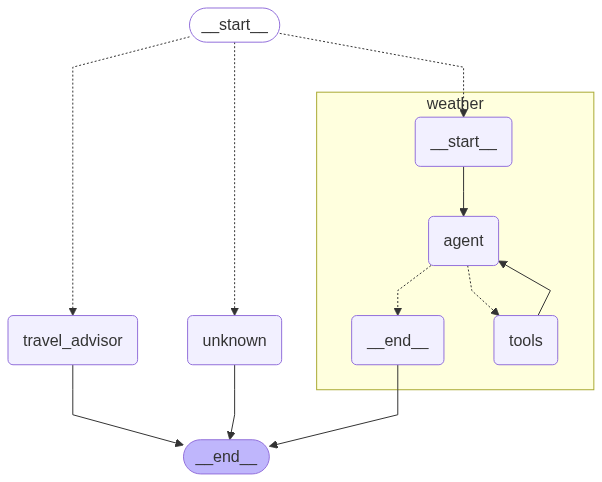

In [13]:
from IPython.display import Image
Image(graph.get_graph(xray=1).draw_mermaid_png())

In [12]:
messages = [HumanMessage(content="What can you tell me about the weather in Mumbai")]

for msg in messages:
    msg.pretty_print()

async for event in graph.astream(input={"messages": messages}, stream_mode="updates"):
    for node in graph.nodes.keys():
        node_output = event.get(node, {})
        if node_output is not None:
            output_msgs = node_output.get("messages", [])
            for msg in output_msgs:
                msg.pretty_print()

================================ Human Message =================================

What can you tell me about the weather in Mumbai
Router response: tool='weather'
================================ Human Message =================================

What can you tell me about the weather in Mumbai
================================== Ai Message ==================================

I currently have access to weather information only for Chicago, New York, and Los Angeles. If you'd like, I can provide you with the weather details for any of these cities. Let me know!


## Key Takeaways

The Routing/Supervisor pattern demonstrates several important concepts:

1. **Intelligent Request Routing**: The router analyzes intent and directs requests appropriately
2. **Specialized Agent Handling**: Each agent can focus on its domain expertise
3. **Graceful Fallback**: Unknown requests are handled with helpful error messages
4. **Structured Decision Making**: Using Pydantic ensures consistent routing logic
5. **Scalable Architecture**: Easy to add new specialized agents

## Understanding the Flow

In our test above:
1. **User asks about Mumbai weather**
2. **Router identifies this as a weather request** (prints: `Router response: tool='weather'`)
3. **Weather agent processes the request** but doesn't have Mumbai data
4. **Weather agent responds helpfully** with available options

## When to Use Routing/Supervisor Pattern

### Ideal Scenarios:
- **Multi-domain applications** (customer service, enterprise tools)
- **Specialized expertise needed** (legal, medical, technical support)
- **Scalable agent systems** with growing capabilities
- **Quality control** where different agents have different skill levels

### Benefits:
- **Improved response quality** through specialization
- **Better resource utilization** (route simple queries to lightweight agents)
- **Easier maintenance** (update one agent without affecting others)
- **Clear separation of concerns**

## Next Steps

This routing pattern can be extended with:
- **More sophisticated routing logic** (confidence scores, fallback chains)
- **Dynamic agent loading** based on availability
- **Load balancing** between multiple instances of the same agent type
- **Conversation state management** for multi-turn routing

The next notebook will explore **Reflection** patterns for self-improving agents.